In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [ ]:
df=pd.read_csv('https://drive.google.com/uc?export=download&id=1sHR0Yor1dniuTP2U29vi7joMcZ_7tXxP')

In [ ]:
X = df.drop(columns=['y_sum', 'y_binary'])
y_binary = df.iloc[:, -1]
y_sum = df.iloc[:, -2]

In [ ]:
def get_binary_columns(df):
    binary_columns = []
    for column in df.columns:
        unique_values = df[column].unique()
        if len(unique_values) == 2:
            binary_columns.append(column)
    return binary_columns

binary_columns = get_binary_columns(X)
cont_columns = [column for column in X.columns if column not in binary_columns]

In [ ]:
X = X[binary_columns + cont_columns]
df_binary = pd.concat([X, y_binary], axis=1)
df_sum = pd.concat([X, y_sum], axis=1)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
split=list(enumerate(skf.split(df_binary,df_binary.y_binary)))

In [ ]:
folds={i[0]:i[1][1] for i in split}
folds

{0: array([    1,     5,     7, ..., 64414, 64415, 64417]),
 1: array([    0,     8,    21, ..., 64404, 64412, 64419]),
 2: array([    2,    11,    13, ..., 64405, 64409, 64416]),
 3: array([    3,     6,    22, ..., 64408, 64410, 64421]),
 4: array([    4,     9,    10, ..., 64403, 64418, 64420])}

In [ ]:
train_idx = np.concatenate((folds[0], folds[1], folds[2]))
val_idx = folds[3]
test_idx = folds[4]

In [ ]:
len(train_idx), len(val_idx), len(test_idx)

(38654, 12884, 12884)

In [ ]:
X_train = X.iloc[train_idx]
X_val = X.iloc[val_idx]
X_test = X.iloc[test_idx]

y_binary_train = y_binary.iloc[train_idx]
y_binary_val = y_binary.iloc[val_idx]
y_binary_test = y_binary.iloc[test_idx]

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomScaler(BaseEstimator,TransformerMixin):
    # note: returns the feature matrix with the binary columns ordered first
    def __init__(self,bin_col,cont_col):
        self.scaler = StandardScaler()
        self.bin_col = bin_col
        self.cont_col = cont_col

    def fit(self, X):
        self.scaler.fit(X[self.cont_col])
        return self

    def transform(self, X):
        X_tail = self.scaler.transform(X[self.cont_col])
        return np.concatenate((X[self.bin_col],X_tail), axis=1)

In [ ]:
scale = CustomScaler(bin_col=binary_columns,cont_col=cont_columns)
X_train = scale.fit_transform(X_train)
X_val = scale.transform(X_val)
X_test = scale.transform(X_test)

In [ ]:
import torch # torch

from torchvision import transforms # transform is used for data pre-processing
from torch.utils import data as Data
from torch.utils.data import Dataset # for dataset construction
from torch.utils.data import DataLoader

import torch.optim as optim

import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [ ]:
X.head(5)

,SEXVAR,EXERANY2,CVDINFR4,Florida,Idaho,Indiana,Maine,Nevada,Oregon,Rhode Island,...,_MENT14D,DIFFDRES,DIFFALON,COVIDPOS,SLEPTIM1,WEIGHT2,HEIGHT3,CNCRAGE,_AGE80,_DRNKWK2
0,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,8.0,63.502880,1.8034,0.0,79.0,2.300000e-01
1,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,6.0,77.110640,1.5748,0.0,62.0,5.397605e-81
2,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,7.0,82.985907,1.6764,0.0,79.0,2.300000e-01
3,1,1,0,1,0,0,0,0,0,0,...,1,0,1,0,8.0,77.110640,1.7780,0.0,80.0,5.397605e-81
4,1,1,1,1,0,0,0,0,0,0,...,2,0,0,0,7.0,102.058200,1.7780,0.0,68.0,4.700000e-01


In [ ]:
XTrain = torch.from_numpy(X_train).float()
XVal = torch.from_numpy(X_val).float()
XTest = torch.from_numpy(X_test).float()

yBinaryTrain = torch.from_numpy(y_binary_train.values)
yBinaryVal = torch.from_numpy(y_binary_val.values)
yBinaryTest = torch.from_numpy(y_binary_test.values)

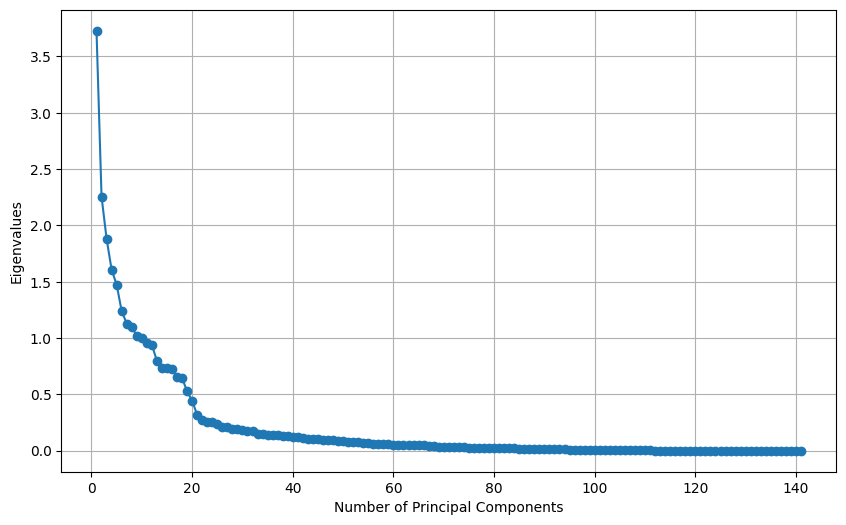

In [ ]:
cov_matrix = np.cov(X_train.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.decomposition import PCA

n_components = 20
pca = PCA(n_components=n_components)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_train_pca

array([[-1.47125828,  0.37819623, -0.77443153, ...,  1.15140333,
         1.2605999 , -0.16233926],
       [-0.90709721, -1.31518925,  0.35371379, ...,  0.17724874,
        -0.19282225,  1.01694077],
       [-0.23682098, -1.15934431, -0.03781325, ..., -0.64361558,
         1.63346028,  0.38485488],
       ...,
       [-1.30979456, -2.17946514,  0.553838  , ...,  0.39362741,
        -0.55142263, -0.57783042],
       [ 4.62940341,  1.62114579, -1.32775893, ..., -1.54282717,
        -0.0820887 ,  0.25895171],
       [ 3.62466108, -1.04932989, -0.37950284, ..., -0.07923108,
         0.10784457, -0.06365723]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

RFC = RandomForestClassifier(n_estimators=100, random_state=42)

RFC.fit(X_train_pca, y_binary_train)

X_test_pca = pca.transform(X_test)
predictions = RFC.predict(X_test_pca)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_binary_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8848183793852841


In [ ]:
np.unique(predictions, return_counts = True)

(array([0, 1]), array([12675,   209]))

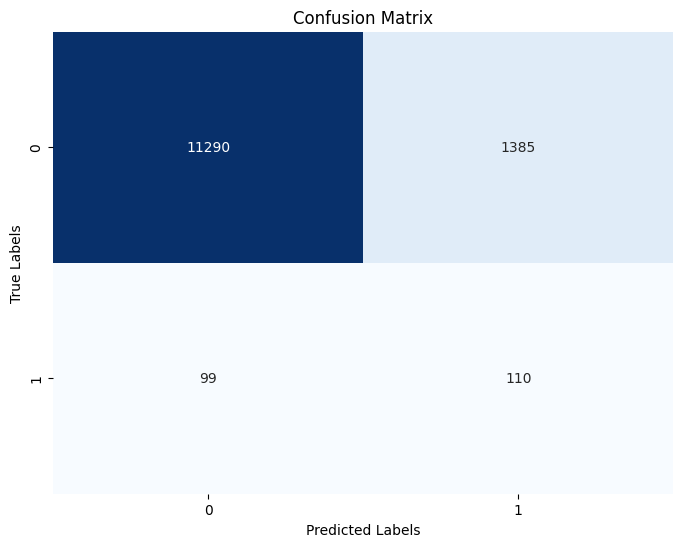

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(predictions, y_binary_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Weighted RFC

In [ ]:
weight = np.unique(y_binary_train, return_counts = True)
print(weight)
weights = weight[1]/ len(y_binary_train)
class_weight = {0: weights[0], 1: weights[1]}
print(class_weight)

RFC2 = RandomForestClassifier(n_estimators=100, class_weight = class_weight, random_state=42)

RFC2.fit(X_train_pca, y_binary_train)

X_test_pca = pca.transform(X_test)
predictions2 = RFC2.predict(X_test_pca)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_binary_test, predictions2)
print("Accuracy:", accuracy)

(array([0, 1]), array([34167,  4487]))
{0: 0.8839188699746469, 1: 0.11608113002535313}
Accuracy: 0.8819466004346477


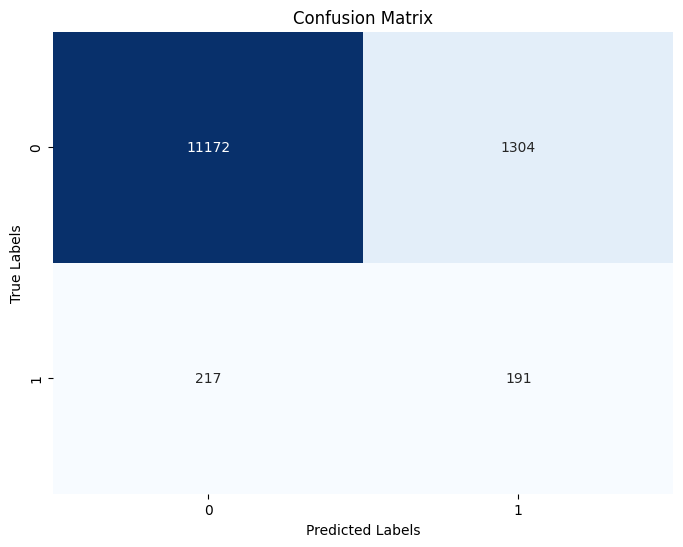

In [ ]:
conf_matrix = confusion_matrix(predictions2, y_binary_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(RFC2, X_train, y_binary_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.89108783 0.89664985 0.8960031  0.89302807 0.89598965]
Mean CV Score: 0.8945517006765156


In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

logistic_regression.fit(X_train, y_binary_train)

# Make predictions on the test data
test_predictions = logistic_regression.predict(X_test)

# Calculate the accuracy of the model on the test data
test_accuracy = accuracy_score(y_binary_test, test_predictions)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8967711890717168


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', class_weight=class_weight)
svm_classifier.fit(X_train, y_binary_train)
test_predictions = svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_binary_test, test_predictions)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.8839646072648246
